In [1]:
import numpy as np
from numpy.random import randn
import math
import matplotlib.pyplot as plt

from matplotlib_helper import *

In [2]:
def f_radar(x, dt):
    F = np.array([[1, dt, 0],
                  [0, 1, 0],
                  [0, 0, 1]], dtype=float)

    return F @ x

In [3]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[1] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx ** 2 + dy ** 2)
    elavation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

In [4]:
from numpy.linalg import norm
from math import atan2

class RadarStation:

    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    def reading_of(self, ac_pos):
        """ （直距離、仰角）を返す。仰角の単位は、ラジアン。"""
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg

    def noisy_reading(self, ac_pos):
        """ シミューレートされたノイズを持った　直距離と仰角の観測値を返す. """
        rng, brg = self.reading_of(ac_pos)
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std
        return rng, brg

In [5]:
class ACSim:
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std

    def update(self, dt):
        """ 次の位置を計算して返す。速度をランダムに変動させる。"""
        dx = self.vel * dt + (randn() * self.vel_std) * dt
        self.pos += dx
        return self.pos

In [6]:
# simulation
dt = 3 # 3秒
range_std = 5 # 単位はメートル
elevation_angle_std = math.radians(0.5) # 0.　5 [deg]

ac_pos = (0.0, 1000.0)
ac_vel = (100.0, 0.0)
ac_vel_std = 0.02

ac = ACSim(ac_pos, ac_vel, ac_vel_std)
ac_poss = np.zeros([50, 2])
for i in range(50):
    pos = ac.update(dt)
    ac_poss[i, :] = pos

In [7]:
# simulation => measurement
sim_n = 100

radar_pos = (0.0, 0.0)
range_std_m = 5.0 # [m]
elevation_angle_std = math.radians(0.5) # [rad]
radar = RadarStation(radar_pos, range_std_m, elevation_angle_std)
ac = ACSim(ac_pos, ac_vel, ac_vel_std)

ac_poss = np.zeros([sim_n, 2])
radar_result = np.zeros([sim_n, 2])
for i in range(sim_n):
    pos = ac.update(dt)
    r = radar.noisy_reading(pos)
    ac_poss[i, :] = pos
    radar_result[i, :] = r

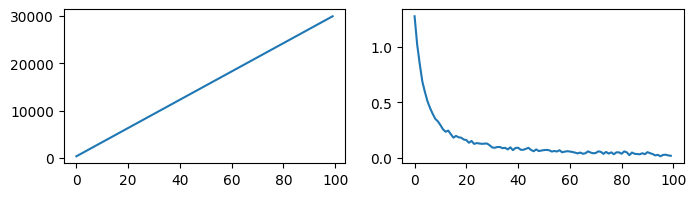

In [8]:
fig = plt.figure(figsize=(8,2))
ax=fig.add_subplot(121)
ax.plot(ac_poss[:,0])
ax2=fig.add_subplot(122)
ax2.plot(radar_result[:,1])

In [9]:
from math import sin, cos, radians

def angle_between(x, y):
    return min(y - x, y - x + 360, y - x - 360, key=abs)

class ManeuveringTarget(object):
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading

        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0

    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy

        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta

        return (self.x, self.y)

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, self.hdg) / steps

        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0

    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps

        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0

In [10]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.0):
        self.std = std_noise

    def sense(self, pos):
        """
        実際の位置（x,y)を受け取り、ノイズを加えた(x', y')を返す
        """
        return (pos[0] + (randn() * self.std), pos[1] + (randn() * self.std))

In [11]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs


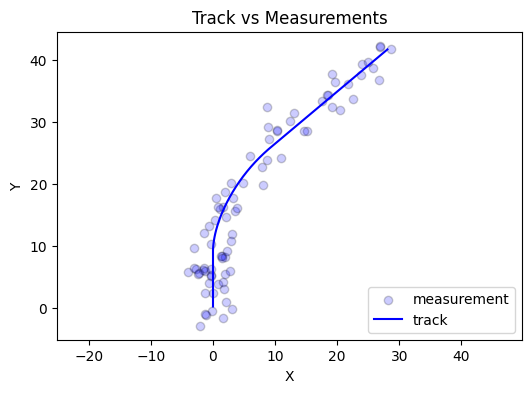

In [12]:
sensor_std = 2.0
track, zs = generate_data(50, sensor_std)
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.scatter(*zip(*zs), edgecolor='k', facecolor='b', alpha=0.2, label='measurement') 
ax.plot(*zip(*track), color='b', label='track')
set_labels(title='Track vs Measurements', x='X', y='Y')
plt.axis('equal')
plt.legend(loc=4)

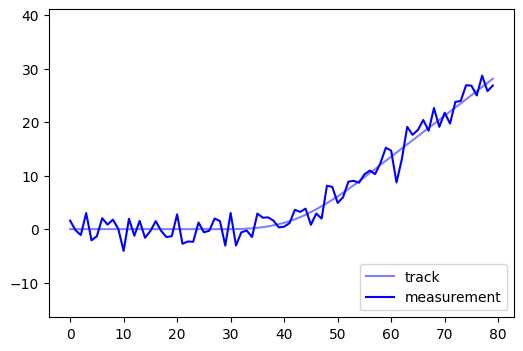

In [13]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(track[:,0], label='track', color='b', alpha=0.5)
ax.plot(zs[:,0], color='b',label='measurement') 
#ax.scatter(np.arange(zs.shape[0]), zs[:,0], edgecolor='k', facecolor='b', alpha=0.2, label='measurement') 
plt.axis('equal')
plt.legend(loc=4)

In [14]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z = 1)
    cvfilter.x = np.array([0.0, 0.0])
    cvfilter.P *= 3
    cvfilter.R *= std ** 2
    cvfilter.F = np.array([[1, dt], [0, 1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

def initialize_filter(kf, std_R=None):
    """ ヘルパー関数:このフィルタは何度も初期化することになる。"""
    kf.x.fill(0.0)
    kf.P = np.eye(kf.dim_x) * 0.1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

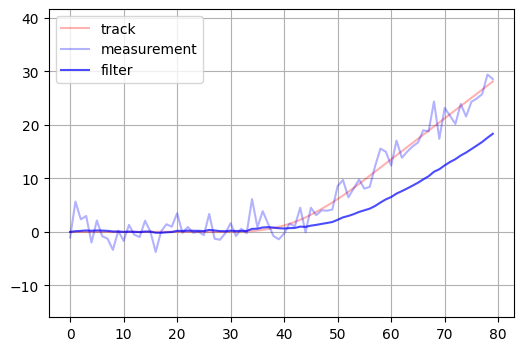

In [15]:
sensor_std = 2.0
dt = 0.1

cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)

track, zs = generate_data(50, sensor_std)

#　フィルタの実行
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(track[:,0], label='track', color='r', alpha=0.3)
ax.plot(zs[:,0], color='b',alpha=0.3, label='measurement') 
plt.plot(kxs[:, 0], color='b',alpha=0.7, label='filter')
#ax.scatter(np.arange(zs.shape[0]), zs[:,0], edgecolor='k', facecolor='b', alpha=0.2, label='measurement') 
plt.axis('equal')
plt.legend()
plt.grid()

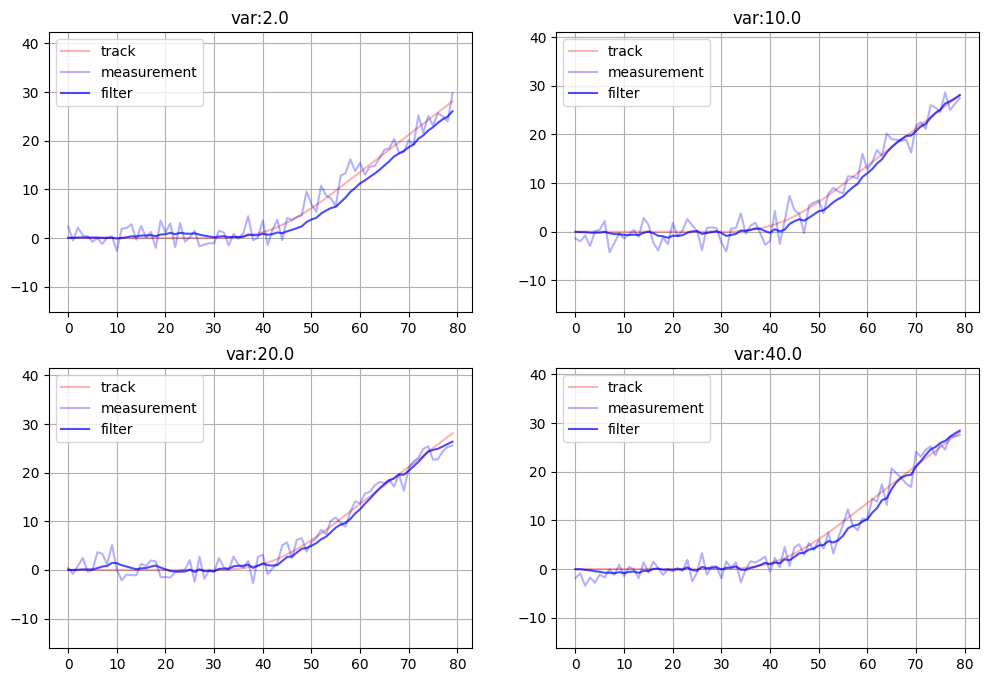

In [16]:
q_vars = [2.0, 10.0, 20.0, 40.0]

fig = plt.figure(figsize = (12, 8))
for i, var in enumerate(q_vars):

    # フィルタをもう一度初期化する。
    dt = 0.1
    initialize_filter(cvfilter)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var)
    track, zs = generate_data(50, sensor_std)
    
    # もう一度追跡を行う。
    cvfilter.x.fill(0.0)
    z_xs = zs[:, 0]
    kxs, _, _, _ = cvfilter.batch_filter(z_xs)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(track[:,0], label='track', color='r', alpha=0.3)
    ax.plot(zs[:,0], color='b',alpha=0.3, label='measurement') 
    ax.plot(kxs[:, 0], color='b',alpha=0.7, label='filter')
    #ax.scatter(np.arange(zs.shape[0]), zs[:,0], edgecolor='k', facecolor='b', alpha=0.2, label='measurement') 
    ax.set_title(f'var:{var}')
    plt.axis('equal')
    plt.legend()
    plt.grid()

In [17]:
def make_ca_filter(dt, std):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = np.array([0.0, 0.0, 0.0])
    cafilter.P *= 3
    cafilter.R *= std
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt], [0, 1, dt], [0, 0, 1]])
    cafilter.H = np.array([[1., 0, 0]])
    return cafilter

def initialize_const_accel(f):
    f.x = np.array([0.0, 0.0, 0.0])
    f.P = np.eye(3) * 3

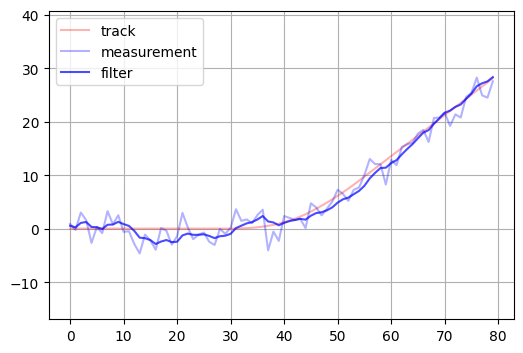

In [18]:
dt = 0.1
cafilter = make_ca_filter(dt, sensor_std)
initialize_const_accel(cafilter)

track, zs = generate_data(50, sensor_std)
z_xs = zs[:, 0]

kxs, _, _, _ = cafilter.batch_filter(z_xs)

fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(track[:,0], label='track', color='r', alpha=0.3)
ax.plot(zs[:,0], color='b',alpha=0.3, label='measurement') 
plt.plot(kxs[:, 0], color='b',alpha=0.7, label='filter')
#ax.scatter(np.arange(zs.shape[0]), zs[:,0], edgecolor='k', facecolor='b', alpha=0.2, label='measurement') 
plt.axis('equal')
plt.legend()
plt.grid()

In [19]:
cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
print(cvfilter.Q)
xs, res = [], []

track, zs = generate_data(150, sensor_std)
z_xs = zs[:, 0]

for z in z_xs:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])

[[5.e-07 1.e-05]
 [1.e-05 2.e-04]]


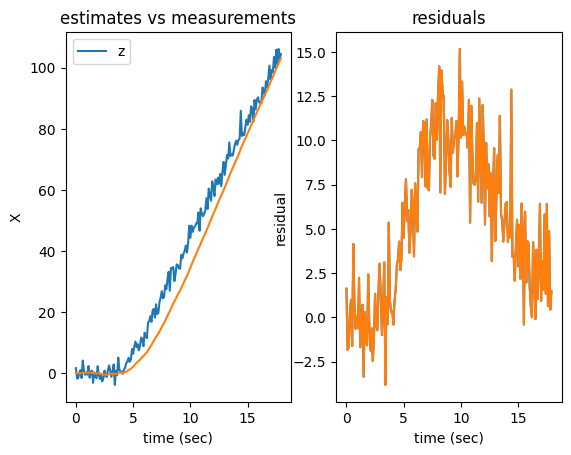

In [20]:
t = np.arange(0, len(xs)*dt, dt)
plt.subplot(121)
plt.plot(t, z_xs, label='z')
plt.plot(t, xs)
plt.legend()
plt.xlabel('time (sec)')
plt.ylabel('X')
plt.title('estimates vs measurements')
plt.subplot(122)
# plot twice so it has the same color as the plot to the left!
plt.plot(t, res)
plt.plot(t, res)
plt.xlabel('time (sec)')
plt.ylabel('residual')
plt.title('residuals')
plt.show()

In [21]:
from scipy.linalg import block_diag

def make_ca2_filter(dt, std):
    cafilter = KalmanFilter(dim_x=6, dim_z=2)
    cafilter.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    cafilter.P *= 3
    cafilter.R *= std
    #print("Q:", cafilter.Q.shape)
    q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.Q = block_diag(q, q)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt, 0, 0, 0], 
                           [0, 1, dt, 0, 0, 0], 
                           [0, 0, 1, 0, 0, 0],
                           [0, 0, 0, 1, dt, 0.5*dt*dt],
                           [0, 0, 0, 0, 1, dt],
                           [0, 0, 0, 0, 0, 1],
                          ],)
    cafilter.H = np.array(
                        [[1.0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1.0, 0, 0],  
                          ])
    return cafilter

def initialize_const_accel(f):
    f.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    f.P = np.eye(6) * 3

In [22]:
dt = 0.1
ca2filter = make_ca2_filter(dt, sensor_std)
#initialize_const_accel(ca2filter)
print("x:", ca2filter.x)
print("P:", ca2filter.P)
print("R:", ca2filter.R)
print("Q:", ca2filter.Q)
print("F:", ca2filter.F)
print("H:", ca2filter.H)
#ca2filter.Q[0:3, 0:3] = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
#ca2filter.Q[3:6, 3:6] = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
xs, ys, res = [], [], []

track, zs = generate_data(150, sensor_std)
z_xs = zs[:, 0]
z_ys = zs[:, 1]

for z in zs:
    z2 = np.array([z[0], z[1]]).T
    ca2filter.predict()
    ca2filter.update(z2)
    xs.append(ca2filter.x[0])
    ys.append(ca2filter.x[3])
    res.append(ca2filter.y[0])

x: [0. 0. 0. 0. 0. 0.]
P: [[3. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 3.]]
R: [[2. 0.]
 [0. 2.]]
Q: [[5.e-07 1.e-05 1.e-04 0.e+00 0.e+00 0.e+00]
 [1.e-05 2.e-04 2.e-03 0.e+00 0.e+00 0.e+00]
 [1.e-04 2.e-03 2.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 5.e-07 1.e-05 1.e-04]
 [0.e+00 0.e+00 0.e+00 1.e-05 2.e-04 2.e-03]
 [0.e+00 0.e+00 0.e+00 1.e-04 2.e-03 2.e-02]]
F: [[1.    0.1   0.005 0.    0.    0.   ]
 [0.    1.    0.1   0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.1   0.005]
 [0.    0.    0.    0.    1.    0.1  ]
 [0.    0.    0.    0.    0.    1.   ]]
H: [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


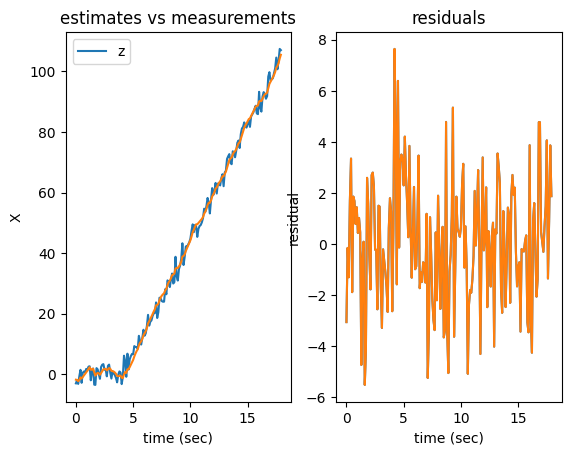

In [23]:
t = np.arange(0, len(xs)*dt, dt)
plt.subplot(121)
plt.plot(t, z_xs, label='z')
plt.plot(t, xs)
plt.legend()
plt.xlabel('time (sec)')
plt.ylabel('X')
plt.title('estimates vs measurements')
plt.subplot(122)
# plot twice so it has the same color as the plot to the left!
plt.plot(t, res)
plt.plot(t, res)
plt.xlabel('time (sec)')
plt.ylabel('residual')
plt.title('residuals')
plt.show()

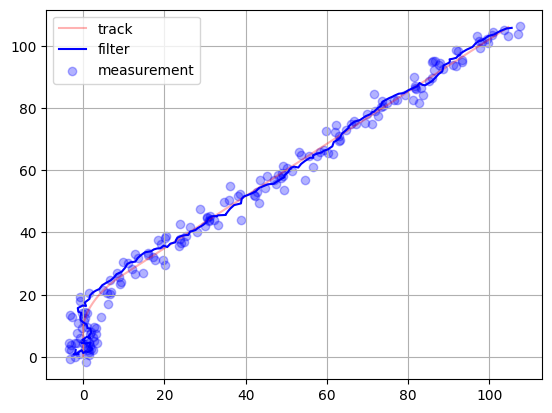

In [24]:
plt.plot(*zip(*track), color="r", alpha=0.3, label="track")
plt.plot(xs, ys, color="b", label="filter")
plt.scatter(*zip(*zs), color="b", alpha=0.3, label="measurement")
plt.legend()
plt.grid()

In [25]:
from radar_simulation import generate_data, generate_data_maneuver, azimuth_to_xy
dt_sec = 0.05
range_std_m = 0.2
elevation_angle_std_deg = 3

track, zs = generate_data_maneuver(dt_sec=dt_sec, steady_count=50, range_std_m=range_std_m, elevation_angle_std_deg=elevation_angle_std_deg)
z_r = zs[:, 0]
z_azimuth = zs[:, 1]

new_xs, new_ys = azimuth_to_xy(*zip(*zs))

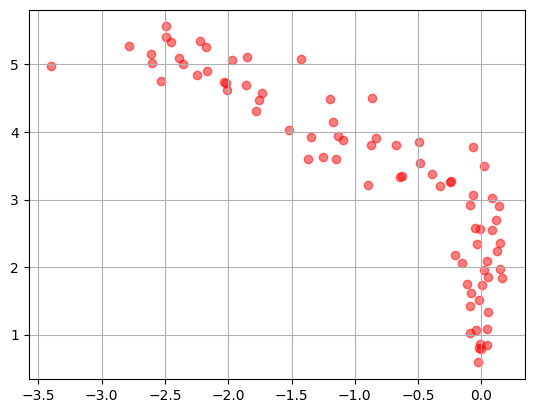

In [26]:
plt.scatter(new_xs, new_ys, color='r', alpha=0.5)
plt.grid()

In [27]:
def f_radar(x, dt):
    """
    状態遷移関数
    状態ベクトルは [x, x方向の速度, y, y方向の速度]
    """

    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)
    return F @ x

In [28]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    azimuth_angle = math.atan2(dy, dx)
    return [slant_range, azimuth_angle]

h_radar.radar_pos = (0, 0)

In [29]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=0.)
kf = UKF(4, 2, dt_sec, fx=f_radar, hx=h_radar, points=points)

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
kf.Q = block_diag(q, q)

kf.R = np.diag([range_std_m**2, elevation_angle_std_deg**2])
kf.x = np.array([0.0, 0.0, 0.0, 0.0])
kf.P *= 10

In [30]:
import math
xs, ys = [], []
for r, azimuth in zs:
    #print(r, math.degrees(azimuth))
    kf.predict()
    kf.update([r, azimuth])
    xs.append(kf.x[0])
    ys.append(kf.x[2])

xs = np.array(xs)
ys = np.array(ys)

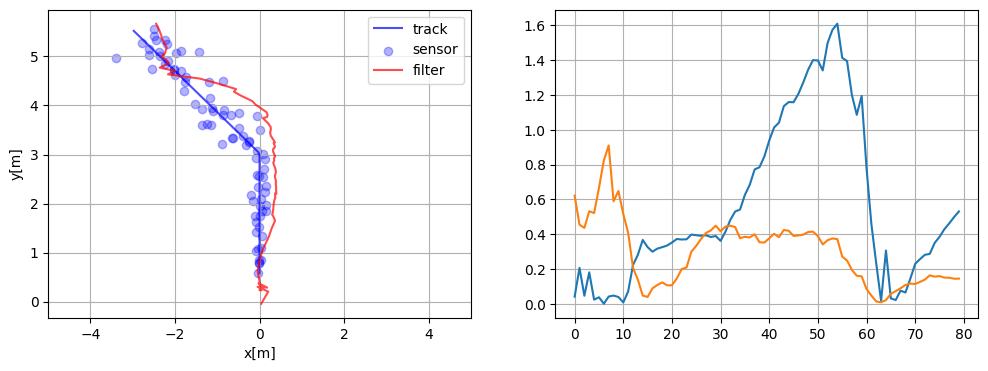

In [31]:
sensor_xs, sensor_ys = azimuth_to_xy(*zip(*zs))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(*zip(*track), color='b', alpha=0.7, label="track")
ax.scatter(sensor_xs, sensor_ys, color='b', alpha=0.3, label="sensor")
ax.plot(xs, ys, color='r', alpha=0.7, label="filter")
ax.legend()
ax.grid()
ax.set_xlabel("x[m]")
ax.set_ylabel("y[m]")
ax.set_xlim([-5,5])

delta_x = np.abs(xs - track[:,0])
delta_y = np.abs(ys - track[:,1])
ax = fig.add_subplot(122)
ax.plot(delta_x, label="delta_x")
ax.plot(delta_y, label="delta_y")
ax.grid()

In [32]:
def f_velocity_radar(x, dt):
    """
    状態遷移関数
    状態ベクトルは [x, x方向の速度, y, y方向の速度]
    """

    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)
    return F @ x

def h_velocity_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    azimuth_angle = math.atan2(dy, dx)
    return [slant_range, azimuth_angle]

h_radar.radar_pos = (0, 0)

def make_ukf_velocity_fiter(p_alpha=2):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=0.)
    kf = UKF(4, 2, dt_sec, fx=f_velocity_radar, hx=h_velocity_radar, points=points)
    
    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
    kf.Q = block_diag(q, q)
    
    kf.R = np.diag([range_std_m**2, elevation_angle_std_deg**2])
    kf.x = np.array([0.0, 0.0, 0.0, 0.0])
    kf.P *= p_alpha

    return kf

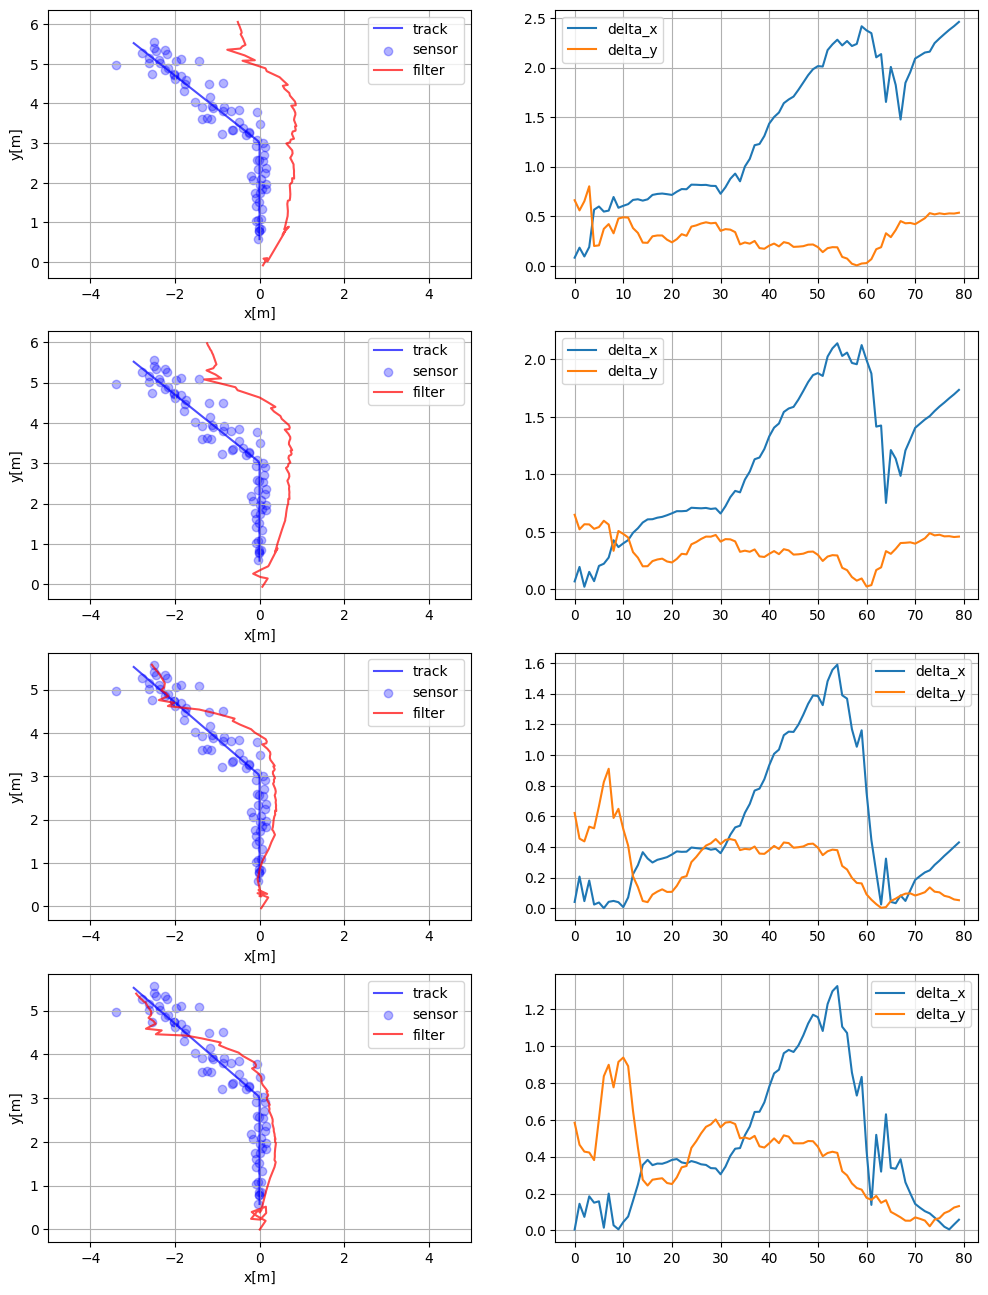

In [33]:
p_alphas = [3, 5, 10, 20]
fig = plt.figure(figsize=(12,16))
for i, alpha in enumerate(p_alphas):
    kf = make_ukf_velocity_fiter(p_alpha=alpha)

    xs, ys = [], []
    for r, azimuth in zs:
        #print(r, math.degrees(azimuth))
        kf.predict()
        kf.update([r, azimuth])
        xs.append(kf.x[0])
        ys.append(kf.x[2])
    
    xs = np.array(xs)
    ys = np.array(ys)

    sensor_xs, sensor_ys = azimuth_to_xy(*zip(*zs))

    ax = fig.add_subplot(len(p_alphas), 2, (2*i)+1)
    ax.plot(*zip(*track), color='b', alpha=0.7, label="track")
    ax.scatter(sensor_xs, sensor_ys, color='b', alpha=0.3, label="sensor")
    ax.plot(xs, ys, color='r', alpha=0.7, label="filter")
    ax.legend()
    ax.grid()
    ax.set_xlabel("x[m]")
    ax.set_ylabel("y[m]")
    ax.set_xlim([-5,5])
    
    delta_x = np.abs(xs - track[:,0])
    delta_y = np.abs(ys - track[:,1])
    ax = fig.add_subplot(len(p_alphas), 2, (2*i)+2)
    ax.plot(delta_x, label="delta_x")
    ax.plot(delta_y, label="delta_y")
    ax.grid()
    ax.legend()

In [40]:
def f_accel_radar(x, dt):
    """
    状態遷移関数
    状態ベクトルは [x, x方向の速度, x方向の加速度、　y, y方向の速度、 y方向の加速度]
    """

    accel_model = np.array([[1, dt, 0.5*dt*dt],
                             [0,  1, dt],
                               [0,  0,  1]], dtype=float)
    F = block_diag(accel_model, accel_model)
    return F @ x

def h_accel_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[3] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    azimuth_angle = math.atan2(dy, dx)
    return [slant_range, azimuth_angle]

h_radar.radar_pos = (0, 0)

def make_ukf_accel_fiter(p_alpha=2):
    points = MerweScaledSigmaPoints(n=6, alpha=.1, beta=2., kappa=-3.)
    kf = UKF(6, 2, dt_sec, fx=f_accel_radar, hx=h_accel_radar, points=points)
    
    q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    kf.Q = block_diag(q, q)
    kf.R = np.diag([range_std_m**2, elevation_angle_std_deg**2])
    kf.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    kf.P *= p_alpha

    return kf

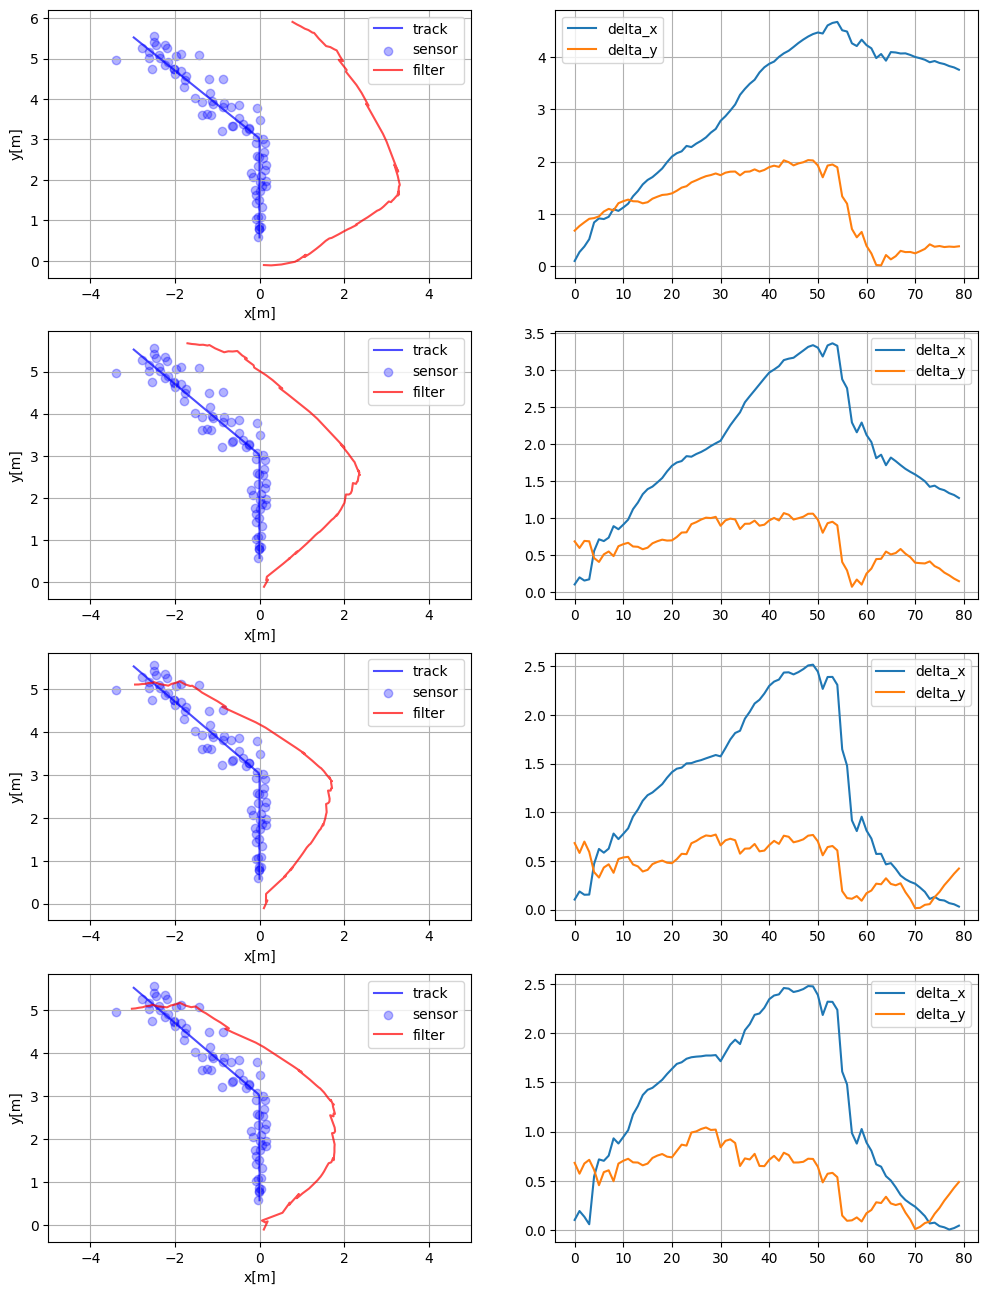

In [35]:
p_alphas = [0.1, 0.5, 1, 1.5]
fig = plt.figure(figsize=(12,16))
for i, alpha in enumerate(p_alphas):
    kf = make_ukf_accel_fiter(p_alpha=alpha)

    xs, ys = [], []
    for r, azimuth in zs:
        #print(r, math.degrees(azimuth))
        kf.predict()
        kf.update([r, azimuth])
        xs.append(kf.x[0])
        ys.append(kf.x[3])
    
    xs = np.array(xs)
    ys = np.array(ys)

    sensor_xs, sensor_ys = azimuth_to_xy(*zip(*zs))

    ax = fig.add_subplot(len(p_alphas), 2, (2*i)+1)
    ax.plot(*zip(*track), color='b', alpha=0.7, label="track")
    ax.scatter(sensor_xs, sensor_ys, color='b', alpha=0.3, label="sensor")
    ax.plot(xs, ys, color='r', alpha=0.7, label="filter")
    ax.legend()
    ax.grid()
    ax.set_xlabel("x[m]")
    ax.set_ylabel("y[m]")
    ax.set_xlim([-5,5])
    
    delta_x = np.abs(xs - track[:,0])
    delta_y = np.abs(ys - track[:,1])
    ax = fig.add_subplot(len(p_alphas), 2, (2*i)+2)
    ax.plot(delta_x, label="delta_x")
    ax.plot(delta_y, label="delta_y")
    ax.grid()
    ax.legend()

In [36]:
dt_sec = 0.05
range_std_m = 0.2
elevation_angle_std_deg = 3
track, zs = generate_data(dt_sec=dt, heading=0, v0_m_sec=1.2, range_std_m=range_std_m, elevation_angle_std_deg=elevation_angle_std_deg)

z_r = zs[:, 0]
z_azimuth = zs[:, 1]

sensor_xs, sensor_ys = azimuth_to_xy(*zip(*zs))

In [37]:
def f_velocity_radar(x, dt):
    """
    状態遷移関数
    状態ベクトルは [x, x方向の速度, y, y方向の速度]
    """

    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)
    return F @ x

def h_velocity_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    azimuth_angle = math.atan2(dy, dx)
    return [slant_range, azimuth_angle]

h_velocity_radar.radar_pos = (0, 0)

def make_ukf_velocity_fiter(range_std_m, elevation_angle_std_deg, p_alpha=2):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.0)
    kf = UKF(4, 2, dt_sec, fx=f_velocity_radar, hx=h_velocity_radar, points=points)
    
    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
    kf.Q = block_diag(q, q)
    
    kf.R = np.diag([range_std_m**2, elevation_angle_std_deg**2])
    kf.x = np.array([0.0, 0.0, 0.0, 0.0])
    kf.P *= p_alpha

    return kf

In [38]:
kf = make_ukf_velocity_fiter(range_std_m, elevation_angle_std_deg, p_alpha=0.1)
kf.x = np.array([0.0, 1.0, 0.0, 0.0])
kf.P = np.eye(4) * 0.1

xs, ys = [], []
for r, azimuth in zs:
    kf.predict()
    kf.update([r, azimuth])
    xs.append(kf.x[0])
    ys.append(kf.x[2])

0.7899777132812102 89.4538198291678
azimuth: 0.0
azimuth: 0.0
azimuth: 0.0
azimuth: 47.60795428522697
azimuth: 3.135086506544805
azimuth: 180.0
azimuth: 0.0
azimuth: -47.60795428522697
azimuth: -3.135086506544805
0.9208968616523361 87.65158781138807
azimuth: -9.390873461380776
azimuth: -7.19452256712716
azimuth: -9.383912276535575
azimuth: -2.714969242471892
azimuth: -9.045862566608072
azimuth: -11.87376751657409
azimuth: -9.397920914655053
azimuth: -15.82007284634291
azimuth: -9.735198551466091
1.2863560681881858 93.0073666543998
azimuth: -4.112395681200559
azimuth: -2.5351225742159476
azimuth: -4.234168522577701
azimuth: 0.6245585681835957
azimuth: -3.856100872982146
azimuth: -5.82287933328421
azimuth: -3.9894909338852953
azimuth: -8.793820222088742
azimuth: -4.36852574004963
1.0025501886113353 91.93455013865061
azimuth: 2.5574024954333554
azimuth: 3.4876473315944656
azimuth: 2.3439091684114537
azimuth: 5.9348117684290305
azimuth: 2.742358550302377
azimuth: 1.5746892866232574
azimuth

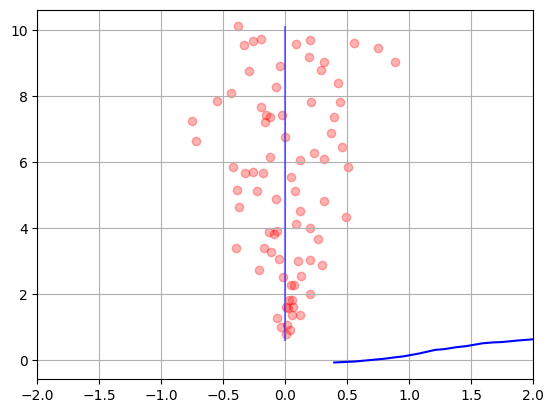

In [39]:
plt.scatter(sensor_xs, sensor_ys, color='r', alpha=0.3)
plt.plot(xs, ys, color="b")
plt.plot(*zip(*track), color="b", alpha=0.5)
plt.xlim([-2,2])
plt.grid()